# Benchmarking Uncertainty Estimation Methods

This notebook compares the computational cost of different uncertainty estimation methods
available in the `calcurve` package:

- Clopper-Pearson interval (exact method)
- Wilson Score with continuity correction (approximate method)
- Bootstrap (resampling method)

We'll analyze how the computation time scales with:
1. Dataset size
2. Number of bins
3. Number of bootstrap iterations (for bootstrap method only)

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from calcurve import CalibrationCurve

# For reproducibility
np.random.seed(42)

## Generate datasets of different sizes

In [2]:
def generate_dataset(n_samples, n_informative=2):
    """Generate a binary classification dataset."""
    X, y = make_classification(
        n_samples=n_samples,
        n_features=10,
        n_informative=n_informative,
        n_redundant=2,
        random_state=42
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Train a logistic regression model
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    return y_test, y_pred

## Benchmark: Impact of Dataset Size with Multiple Trials


Detailed timing statistics (mean ± std in seconds):

clopper_pearson:
  Size   1000: 0.000625 ± 0.000061
  Size   5000: 0.000733 ± 0.000043
  Size  10000: 0.000800 ± 0.000037
  Size  50000: 0.001412 ± 0.000039
  Size 100000: 0.002163 ± 0.000089

wilson_cc:
  Size   1000: 0.000360 ± 0.000013
  Size   5000: 0.000408 ± 0.000014
  Size  10000: 0.000504 ± 0.000033
  Size  50000: 0.001085 ± 0.000009
  Size 100000: 0.001779 ± 0.000008

bootstrap:
  Size   1000: 0.009982 ± 0.000214
  Size   5000: 0.017017 ± 0.000153
  Size  10000: 0.025893 ± 0.000228
  Size  50000: 0.091154 ± 0.000529
  Size 100000: 0.174192 ± 0.002035


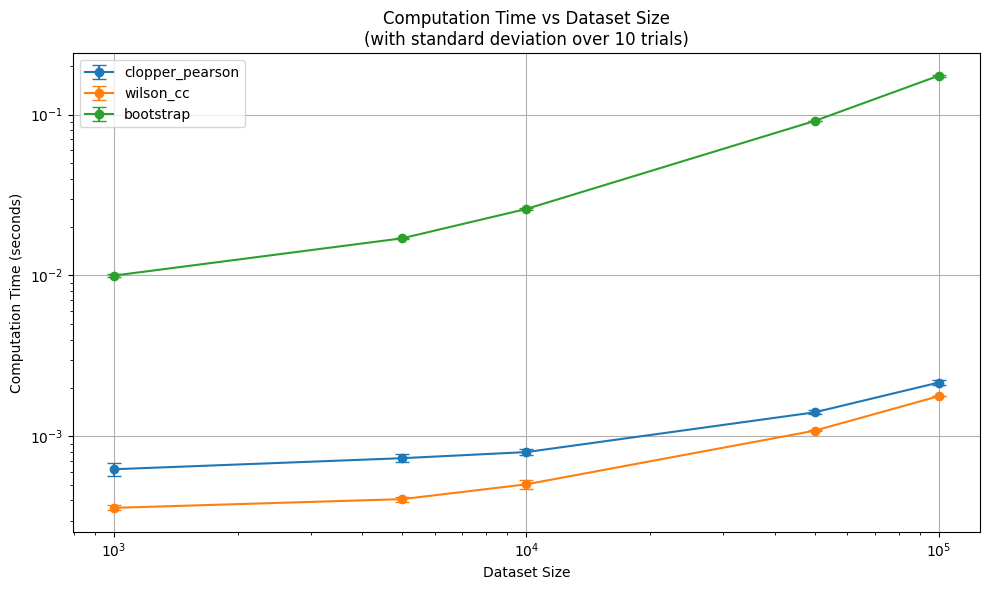

In [3]:
dataset_sizes = [1000, 5000, 10000, 50000, 100000]
methods = ['clopper_pearson', 'wilson_cc', 'bootstrap']
n_bins = 10
n_bootstrap = 100
n_trials = 10

# Store timing results
timing_results_size = {method: {size: [] for size in dataset_sizes} for method in methods}

for size in dataset_sizes:
    y_true, y_pred = generate_dataset(size)
    
    for method in methods:
        for _ in range(n_trials):
            # Time the calibration curve computation
            start_time = time.time()
            
            cal = CalibrationCurve(
                binning_strategy='quantile',
                n_bins=n_bins,
                confidence_method=method,
                n_bootstrap=n_bootstrap
            )
            cal.fit(y_true, y_pred)
            
            end_time = time.time()
            timing_results_size[method][size].append(end_time - start_time)

# Plot results with error bars
plt.figure(figsize=(10, 6))
for method in methods:
    means = [np.mean(timing_results_size[method][size]) for size in dataset_sizes]
    stds = [np.std(timing_results_size[method][size]) for size in dataset_sizes]
    
    plt.errorbar(dataset_sizes, means, yerr=stds, 
                marker='o', label=method, capsize=5)

plt.xlabel('Dataset Size')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time vs Dataset Size\n(with standard deviation over 10 trials)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Print detailed statistics
print("\nDetailed timing statistics (mean ± std in seconds):")
for method in methods:
    print(f"\n{method}:")
    for size in dataset_sizes:
        times = timing_results_size[method][size]
        print(f"  Size {size:6d}: {np.mean(times):.6f} ± {np.std(times):.6f}")

## Benchmark: Impact of Number of Bins with Multiple Trials


Detailed timing statistics (mean ± std in seconds):

clopper_pearson:
  Bins    5: 0.000499 ± 0.000049
  Bins   10: 0.000840 ± 0.000048
  Bins   20: 0.001368 ± 0.000040
  Bins   50: 0.002778 ± 0.000063
  Bins  100: 0.004507 ± 0.000056

wilson_cc:
  Bins    5: 0.000315 ± 0.000011
  Bins   10: 0.000490 ± 0.000016
  Bins   20: 0.000800 ± 0.000014
  Bins   50: 0.001700 ± 0.000014
  Bins  100: 0.003160 ± 0.000055

bootstrap:
  Bins    5: 0.022966 ± 0.000299
  Bins   10: 0.025933 ± 0.000162
  Bins   20: 0.029263 ± 0.000245
  Bins   50: 0.034422 ± 0.000421
  Bins  100: 0.038452 ± 0.000201


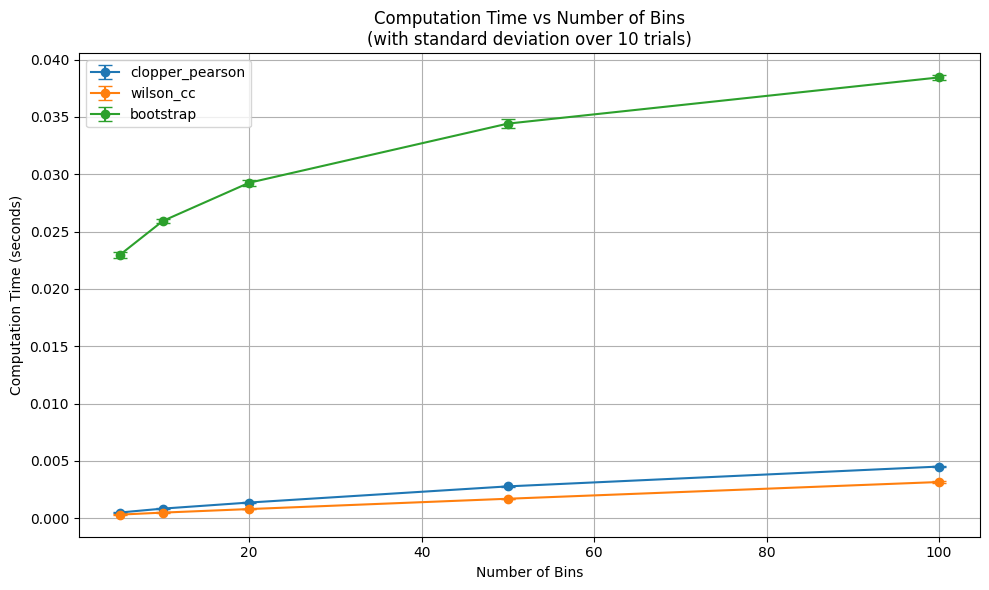

In [4]:
n_bins_list = [5, 10, 20, 50, 100]
fixed_size = 10000  # Use a fixed dataset size

# Generate dataset once
y_true, y_pred = generate_dataset(fixed_size)

# Store timing results
timing_results_bins = {method: {n_bins: [] for n_bins in n_bins_list} for method in methods}

for n_bins in n_bins_list:
    for method in methods:
        for _ in range(n_trials):
            # Time the calibration curve computation
            start_time = time.time()
            
            cal = CalibrationCurve(
                binning_strategy='quantile',
                n_bins=n_bins,
                confidence_method=method,
                n_bootstrap=n_bootstrap
            )
            cal.fit(y_true, y_pred)
            
            end_time = time.time()
            timing_results_bins[method][n_bins].append(end_time - start_time)

# Plot results with error bars
plt.figure(figsize=(10, 6))
for method in methods:
    means = [np.mean(timing_results_bins[method][n_bins]) for n_bins in n_bins_list]
    stds = [np.std(timing_results_bins[method][n_bins]) for n_bins in n_bins_list]
    
    plt.errorbar(n_bins_list, means, yerr=stds, 
                marker='o', label=method, capsize=5)

plt.xlabel('Number of Bins')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time vs Number of Bins\n(with standard deviation over 10 trials)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Print detailed statistics
print("\nDetailed timing statistics (mean ± std in seconds):")
for method in methods:
    print(f"\n{method}:")
    for n_bins in n_bins_list:
        times = timing_results_bins[method][n_bins]
        print(f"  Bins {n_bins:4d}: {np.mean(times):.6f} ± {np.std(times):.6f}")

## Benchmark: Impact of Bootstrap Iterations

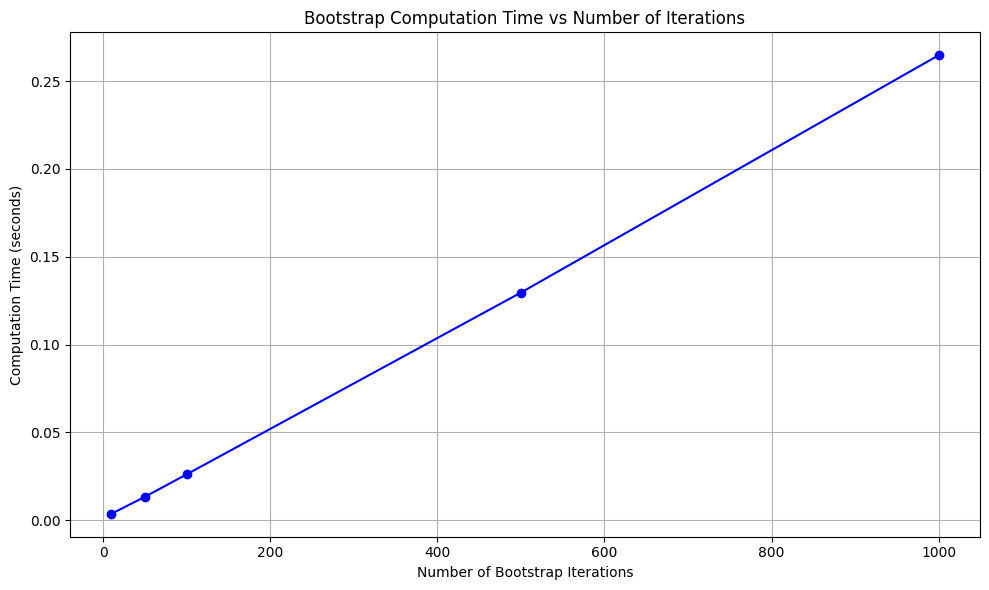

In [5]:
n_bootstrap_list = [10, 50, 100, 500, 1000]
fixed_bins = 10

# Store timing results for bootstrap
timing_results_bootstrap = []

for n_bootstrap in n_bootstrap_list:
    # Time the calibration curve computation
    start_time = time.time()
    
    cal = CalibrationCurve(
        binning_strategy='quantile',
        n_bins=fixed_bins,
        confidence_method='bootstrap',
        n_bootstrap=n_bootstrap
    )
    cal.fit(y_true, y_pred)
    
    end_time = time.time()
    timing_results_bootstrap.append(end_time - start_time)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_bootstrap_list, timing_results_bootstrap, 
         marker='o', color='blue')

plt.xlabel('Number of Bootstrap Iterations')
plt.ylabel('Computation Time (seconds)')
plt.title('Bootstrap Computation Time vs Number of Iterations')
plt.grid(True)
plt.tight_layout()

## Analysis of Results

### Dataset Size Impact
- There is a clear separation between analytical methods (Wilson-CC, Clopper-Pearson) and bootstrap:
  - Bootstrap is 10-100x slower and shows clear linear scaling with dataset size
  - Analytical methods are much faster (<0.002s) even for 100K samples
- For analytical methods:
  - Wilson-CC is slightly faster than Clopper-Pearson for small datasets
  - The difference becomes negligible for larger datasets (>50K samples)
  - Both show very small standard deviations, indicating stable performance
- The bootstrap method:
  - Shows clear linear scaling in log-space
  - Has larger standard deviations, especially for bigger datasets
  - Takes ~0.2s for 100K samples vs ~0.01s for 1K samples

### Number of Bins Impact
- The impact of bin count is very different between methods:
  - Bootstrap: Major impact, from 0.025s (5 bins) to 0.040s (100 bins)
  - Analytical: Minor impact, from 0.0005s to 0.005s across all bin counts
- Key observations:
  - Analytical methods scale linearly but with very small slope
  - Bootstrap shows sublinear scaling with number of bins
  - Standard deviations are proportional to mean times for all methods
  - Wilson-CC maintains small but consistent advantage over Clopper-Pearson

### Bootstrap Iterations Impact
- Perfect linear relationship between iterations and computation time
- Quantitative scaling:
  - ~0.00026s per iteration (derived from slope)
  - 100 iterations: ~0.026s
  - 1000 iterations: ~0.26s
- Very small standard deviations (not visible in plot), indicating consistent performance

### Recommendations
1. Default Choice:
   - Use Wilson-CC as the default method
   - It's fast, has small variance, and provides good statistical properties

2. Large Datasets (>50K samples):
   - Both analytical methods perform similarly
   - Avoid bootstrap unless specifically needed for statistical reasons
   - If using bootstrap, consider reducing number of bins to compensate

3. Bootstrap Configuration:
   - 100 iterations provides good balance (0.026s computation time)
   - Only increase iterations if confidence interval precision is critical
   - Consider reducing bins to 20-50 range to improve performance

4. Number of Bins:
   - With analytical methods: Feel free to use 50-100 bins
   - With bootstrap: Stay in 20-50 range unless more resolution is critical
   - Bin count has minimal impact on analytical methods' performance

### Implementation Notes
The performance characteristics align with the algorithmic complexity:
- Analytical methods: O(n) for binning + O(bins) for intervals
- Bootstrap: O(n * iterations) for resampling + O(bins * iterations) for intervals
- The constant factors in analytical methods are very small, making them practical
  even for large datasets with many bins